In [1]:
import typing as tp
import json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
outputs_dir = Path('.').resolve().parent.parent.parent / "outputs"
log_file_path = outputs_dir / "2022-10-15/21-28-48/image_attention.log"

In [3]:
def load_records(log_path: Path) -> tp.List[tp.Dict[str, tp.Any]]:
    with open(log_path) as f:
        return [json.loads(line.rstrip()) for line in f]

In [4]:
def load_pd_records(log_path: Path) -> pd.DataFrame:
    files_records = load_records(log_file_path)
    log_records_df = pd.json_normalize(files_records).drop(columns=['message', 'asctime'])
    return log_records_df

In [ ]:
log_records_df = load_pd_records(log_file_path)
log_records_df.head()

In [6]:
zero_shot_records = log_records_df[log_records_df['type'] == 'zero_shot']
assert len(zero_shot_records) == 1

zero_shot_preds_path = Path(zero_shot_records.iloc[0]['preds_path'])
zero_shot_preds = np.load(zero_shot_preds_path)
zero_shot_preds.shape

(8041,)

In [7]:
test_labels_path = zero_shot_preds_path.parent.parent / "gold_labels" / "test_labels.npy"
test_labels = np.load(test_labels_path)
test_labels.shape

(8041,)

In [11]:
searcher_results_df = log_records_df[log_records_df['type'] == 'searcher_result']
searcher_preds_path = searcher_results_df.sort_values(by='acc1', ascending=False).iloc[0]['preds_path']
searcher_preds = np.load(searcher_preds_path)
searcher_preds.shape

(8041,)

In [12]:
zero_shot_mask = (zero_shot_preds == test_labels)
searcher_mask = (searcher_preds == test_labels)

In [14]:
tt = (zero_shot_mask & searcher_mask).sum()
tf = (zero_shot_mask & ~searcher_mask).sum()
ft = (~zero_shot_mask & searcher_mask).sum()
ff = (~zero_shot_mask & ~searcher_mask).sum()

pd.DataFrame([[tt, tf], [ft, ff]], columns=['T', 'F'], index=['T', 'F'])

,T,F
T,4135,337
F,467,3102


In [16]:
(4135 + 337) / 8041

0.5561497326203209

In [18]:
(~zero_shot_mask & searcher_mask).nonzero()

(array([   0,   29,   65,  105,  122,  136,  140,  144,  155,  181,  191,
         243,  246,  297,  334,  339,  373,  374,  405,  421,  451,  453,
         455,  470,  471,  514,  520,  528,  539,  552,  556,  577,  579,
         626,  632,  655,  693,  696,  724,  727,  733,  743,  746,  773,
         781,  823,  840,  913,  938,  986, 1010, 1017, 1018, 1019, 1041,
        1090, 1091, 1097, 1112, 1152, 1158, 1174, 1181, 1192, 1203, 1240,
        1272, 1321, 1347, 1353, 1375, 1397, 1422, 1431, 1438, 1439, 1456,
        1466, 1472, 1473, 1478, 1488, 1531, 1539, 1545, 1551, 1570, 1574,
        1580, 1602, 1628, 1635, 1645, 1650, 1657, 1673, 1680, 1689, 1690,
        1696, 1701, 1781, 1785, 1789, 1798, 1836, 1867, 1890, 1924, 1930,
        1959, 1984, 2000, 2003, 2012, 2080, 2135, 2174, 2187, 2210, 2212,
        2215, 2228, 2231, 2238, 2296, 2367, 2387, 2409, 2418, 2436, 2439,
        2468, 2471, 2492, 2505, 2506, 2533, 2540, 2564, 2584, 2591, 2596,
        2600, 2619, 2630, 2641, 2642, 

### Cache analysis

In [21]:
from collections import Counter

In [49]:
cache_df = log_records_df[log_records_df['type'] == 'cache_info']
cache_df.head()

,name,levelname,acc1,acc5,preds_path,type,cache_size,cache_inds_path,cache_strategy._target_,cache_strategy.topk,alpha,cache_value_strategy._target_,cache_weights_strategy._target_,cache_weights_strategy.beta
2,image_attention,INFO,69.387755,96.428571,NaN,cache_info,196.0,/home/myurachinskiy/CLIP/summer-clip/outputs/2...,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,NaN,NaN,NaN,NaN
59,image_attention,INFO,70.153061,95.408163,NaN,cache_info,392.0,/home/myurachinskiy/CLIP/summer-clip/outputs/2...,summer_clip.clip_searcher.cache_strategy.TopKS...,2.0,NaN,NaN,NaN,NaN
116,image_attention,INFO,66.197183,93.982074,NaN,cache_info,781.0,/home/myurachinskiy/CLIP/summer-clip/outputs/2...,summer_clip.clip_searcher.cache_strategy.TopKS...,4.0,NaN,NaN,NaN,NaN
173,image_attention,INFO,65.369650,92.996109,NaN,cache_info,1542.0,/home/myurachinskiy/CLIP/summer-clip/outputs/2...,summer_clip.clip_searcher.cache_strategy.TopKS...,8.0,NaN,NaN,NaN,NaN
230,image_attention,INFO,62.144790,92.151556,NaN,cache_info,2956.0,/home/myurachinskiy/CLIP/summer-clip/outputs/2...,summer_clip.clip_searcher.cache_strategy.TopKS...,16.0,NaN,NaN,NaN,NaN


In [50]:
cache_labels_path = log_file_path.parent / "gold_labels" / "cache_labels.npy"
cache_labels = np.load(cache_labels_path)
cache_labels.shape

(6509,)

In [51]:
def create_cache_k_df(cache_inds: np.ndarray, cache_labels: np.ndarray) -> pd.DataFrame:
    cache_labels_counts = Counter(cache_labels[cache_inds])
    sum_cache_counts = np.array(list(cache_labels_counts.values())) / sum(cache_labels_counts.values())
    return pd.DataFrame({'label': cache_labels_counts.keys(), 'count': sum_cache_counts})

In [52]:
cache_ks_dfs = []

for _, cache_row in cache_df.iterrows():
    cache_inds = np.load(cache_row['cache_inds_path'])
    cache_k_df = create_cache_k_df(cache_inds, cache_labels)
    cache_k_df['k'] = cache_row['cache_strategy.topk']
    cache_ks_dfs.append(cache_k_df)

cache_ks_df = pd.concat(cache_ks_dfs, ignore_index=True)
cache_ks_df.head()

,label,count,k
0,124,0.005102,1.0
1,164,0.005102,1.0
2,1,0.005102,1.0
3,3,0.005102,1.0
4,2,0.005102,1.0


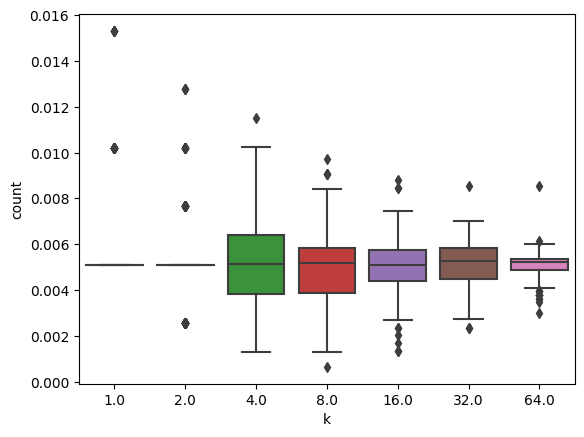

In [53]:
sns.boxplot(data=cache_ks_df, x='k', y='count', orient='v')
plt.savefig('data/cache_classes_1.pdf')

### Ranks analysis

In [5]:
log_file_path = outputs_dir / "2022-11-03/19-33-50/image_attention.log"

In [6]:
log_records_df = load_pd_records(log_file_path)
log_records_df.head()

,name,levelname,acc1,acc5,logits_path,type,cache_size,cache_strategy._target_,cache_strategy.topk,alpha,cache_value_strategy._target_,cache_weights_strategy._target_,cache_weights_strategy.beta
0,image_attention,INFO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,image_attention,INFO,37.506173,89.444444,/home/myurachinskiy/CLIP/summer-clip/outputs/2...,zero_shot,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,image_attention,INFO,50.000000,90.000000,NaN,cache_info,10.0,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,NaN,NaN,NaN,NaN
3,image_attention,INFO,37.506173,89.444444,NaN,searcher_result,NaN,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,0.0,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1
4,image_attention,INFO,37.506173,89.456790,NaN,searcher_result,NaN,summer_clip.clip_searcher.cache_strategy.TopKS...,1.0,0.1,summer_clip.clip_searcher.cache_value_strategy...,summer_clip.clip_searcher.cache_weights_strate...,0.1


In [7]:
zero_shot_records = log_records_df[log_records_df['type'] == 'zero_shot']
assert len(zero_shot_records) == 1

zero_shot_logits_path = Path(zero_shot_records.iloc[0]['logits_path'])
zero_shot_logits = np.load(zero_shot_logits_path)
zero_shot_logits.shape

(8100, 10)

In [8]:
zero_shot_ranks = np.argsort(-zero_shot_logits, axis=1)
zero_shot_ranks = np.argsort(zero_shot_ranks, axis=1)
zero_shot_ranks.shape

(8100, 10)

In [9]:
zero_shot_ranks[0]

array([2, 3, 4, 6, 9, 0, 1, 8, 5, 7])

In [10]:
zero_shot_logits[0]

array([20.5 , 20.23, 20.17, 19.42, 16.62, 20.9 , 20.55, 17.11, 19.97,
       18.58], dtype=float16)

In [11]:
test_labels_path = log_file_path.parent / "gold_labels" / "test_labels.npy"
test_labels = np.load(test_labels_path)
test_labels = test_labels[:, np.newaxis]
test_labels.shape

(8100, 1)

In [12]:
labels_ranks = np.take_along_axis(zero_shot_ranks, test_labels, axis=1).squeeze(axis=1)
labels_ranks.shape

(8100,)

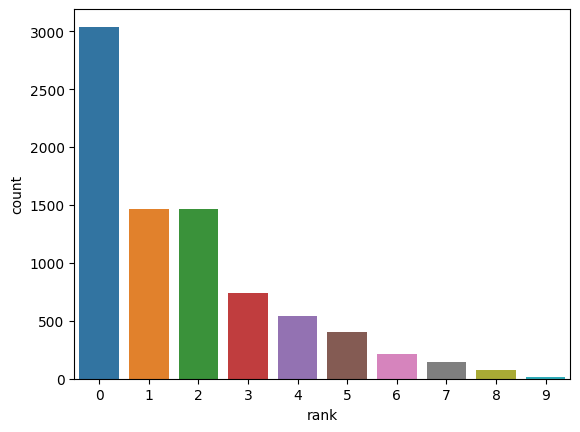

In [15]:
unique_ranks, ranks_counts = np.unique(labels_ranks, return_counts=True)

sns.barplot(x=unique_ranks, y=ranks_counts)
plt.ylabel('count')
plt.xlabel('rank')
plt.savefig('data/ranks_1.pdf')

In [16]:
ranks_counts[0] / ranks_counts.sum()

0.3751851851851852